# **Importing**

In [1]:
%%bash
export PATH=/usr/local/cuda-12.1/bin:$PATH
CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib
python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

bash: /home/ai-05/miniconda3/lib/libtinfo.so.6: no version information available (required by bash)
2023-05-18 14:38:12.865354: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 14:38:12.898584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 14:38:13.386267: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-18 14:38:13.965738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
%cd /home/ai-05/Desktop/sdp

/home/ai-05/Desktop/sdp


In [3]:
!echo $PATH

/bin/bash: /home/ai-05/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/ai-05/Desktop/sdp/test_1/bin:/usr/local/cuda-12.1/bin:/home/ai-05/Desktop/sdp/test_1/bin:/home/ai-05/miniconda3/bin:/home/ai-05/miniconda3/condabin:/usr/lib/nvidia-cuda-toolkit/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [2]:
import json
import os
import pathlib
import random
from datetime import datetime
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras_tuner import Hyperband, Objective, BayesianOptimization
from tensorflow.keras.callbacks import ModelCheckpoint

2023-05-20 03:07:39.874244: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-20 03:07:39.966593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 03:07:40.558317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
gpu = tf.config.list_physical_devices('GPU')
print(gpu)
if gpu:
    tf.config.experimental.set_virtual_device_configuration(gpu[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-20 03:08:07.802677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 03:08:07.858272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 03:08:07.858424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
NEWMODELNAME = "ResNet50-STBv1.0_19"
BASEMODELNAME = "ResNet50-STBv1.0_18"

# **Data generator**

In [4]:
def ds_generator(path, batch_size=16, to_1_hot=False, shuffle=True, image_height=224, image_width=224, seed=123, num_classes=3):
    dir = pathlib.Path(path)


    ds = tf.keras.utils.image_dataset_from_directory(
        dir,
        seed=seed,
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=shuffle)
    
    if to_1_hot:
        # Create a function to convert labels to one-hot encoding
        num_classes = num_classes
        def to_one_hot(x, y):
            num_classes = 3
            y_one_hot = tf.one_hot(y, num_classes)
            return x, y_one_hot
        ds = ds.map(to_one_hot)
    
    return ds

In [5]:
train_ds = ds_generator("Training Set", 16, True, num_classes=4)
test_ds = ds_generator("dcrpi-b", 16,True, shuffle = False, num_classes=4)

Found 66053 files belonging to 4 classes.
Found 231 files belonging to 4 classes.


2023-05-20 03:09:59.465792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 03:09:59.466086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-20 03:09:59.466214: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# **Prep**

In [ ]:
block_layer_index = {
    0: [1,7,'conv1'],
    1: [7,19,'conv2_block1'],
    2: [19,29,'conv2_block2'],
    3: [29,39,'conv2_block3'],
    4: [39,51,'conv3_block1'],
    5: [51,61,'conv3_block2'],
    6: [61,71,'conv3_block3'],
    7: [71,81,'conv3_block4'],
    8: [81,93,'conv4_block1'],
    9: [93,103,'conv4_block2'],
    10: [103,113,'conv4_block3'],
    11: [113,123,'conv4_block4'],
    12: [123, 133,'conv4_block5'],
    13: [133,143,'conv4_block6'],
    14: [143,155,'conv5_block1'],
    15: [155,165,'conv5_block2'],
    16: [165, -1,'conv5_block3']
 }

In [ ]:
model = tf.keras.models.load_model(f"Models/{BASEMODELNAME}")

# **Tuner**

In [ ]:
tuner_path = f'Tuner/{BASEMODELNAME}'
num_trials = 30
tunable_indices = [0,1,2,3,4,5,6,7]

In [ ]:
def retrieve_trials(tuner_path, num_trials, tunable_indices):
    """
        'Args': 
            tuner_path: str something similiar to 'Tuner/ResNet50-STBv1.0_15'
            num_trials: int (count them)
            tunable_indices: list(int) to tune them
        'Returns':
            a dict of dict in a panda DataFrame
            cols: the trials 0 1 2 ...
            rows: the name of the hps

    """
    hps_trials = {}
    for i in range(num_trials):
        f = open(f"{tuner_path}/HB_tuner/trial_00{i:02d}/trial.json", 'r')
        hps_trial = json.load(f)
        hps_trials[i] = hps_trial['hyperparameters']['values']
        
    d = pd.DataFrame(hps_trials)
    d = d.fillna(-1)
    for i in range(len(d.columns)): d[i] = d[i].astype(int)

    name = lambda i: block_layer_index[i][2]
    # in tunable_indices and already in hps_trials
    names = [name(t) for t in tunable_indices if name(t) in d.index] 
    d.T[names].T

    return d

In [ ]:
def comp(hps, d_i):
    # compares two dicts if they are equal 
    for k in hps:
        if k not in d_i.index or  hps[k] != d_i[k]: return False
        else: continue
    return True

In [ ]:
def build_model(hp):
    
    resnet_base = model.layers[2]
    resnet_base.trainable = False

    name = lambda i: block_layer_index[i][2]
    names = list(map(name, tunable_indices))

    hps = {}
    for i,name_ in enumerate(names):
        hps[name_] = hp.Choice(name_, [True,False]) == True
    
    d = retrieve_trials( tuner_path, num_trials, tunable_indices)
    exists = True
    while exists:
        checks = []
        for i in range(len(d.columns)):
            equal = comp(hps,d[i])
            checks.append(equal)
            if equal: break
        checks = np.array(checks)
        exists = np.any(checks) # If there is any True value returns True
        
        if exists:
            print(f"HP combination already exists with the following values:{hps}")
        else:print(f"HP combination is new.\n{hps}")
             
        # Flip the value of the boolean at the chosen key
        flip_key = random.choice(tunable_indices)
        flip_key = name(flip_key)
        hps[flip_key] = not hps[flip_key]

    for bli_k, bli_v in block_layer_index.items():
        if bli_k in tunable_indices:
            for layer in resnet_base.layers[bli_v[0]:bli_v[1]]:
                layer.trainable = hps[name(bli_k)]
        
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.metrics.Recall()])
    return model
    

In [ ]:
from keras_tuner.engine.hyperparameters import HyperParameters

# Define the hyperparameters
hp = HyperParameters()

In [ ]:
tuner = Hyperband(
    build_model,
    objective=Objective('val_recall', direction='max'),
    max_epochs=20,
    factor=3,
    overwrite=True,
    directory=f'Tuner/{NEWMODELNAME}',
    project_name='HB_tuner')

In [ ]:
%pip install keras-tuner[bayesian]

In [ ]:
tuner = BayesianOptimization(
    hypermodel=build_model,
    objective=Objective('val_recall', direction='max'),
    max_trials=50,
    seed=123
)


In [ ]:
tuner.search_space_summary(extended=False)

In [ ]:
log_dir = f"logs/{NEWMODELNAME}"

# create a TensorBoard callback to visualize training metrics
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# # Create the TrialCheckpoint callback
# class MyModelCheckpoint (ModelCheckpoint):
#     def __init__(self, *args, **kwargs):
#         self.now = 0
#         super(MyModelCheckpoint, self).__init__(
#             filepath = self.get_chpt_dir(),
#             save_weights_only=False,
#             save_best_only=True,
#             save_freq='epoch',
#             verbose=1
#         )
        
    
#     def on_epoch_end(self, epoch, logs=None):
#         super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)
#         self.now = datetime.now().strftime("%Y%m%d%H%M%S")
 
    
#     def get_chpt_dir(self):
#         return f"Checkpoint/{NEWMODELNAME}/{self.now}_"+"{epoch:02d}.h5"

In [ ]:
tuner.search(train_ds, epochs=20, validation_data=test_ds,callbacks=[tensorboard_callback]) #MyModelCheckpoint(), 

# **Results (Tuner)**

In [ ]:
tuner.results_summary(num_trials=30)

In [ ]:
all_hps = tuner.get_best_hyperparameters(num_trials=30)

In [ ]:
test_ds = ds_generator("dcrpi-167", 16 , True,False)

In [ ]:
for i,hps in enumerate(all_hps):
    print(f"best trial - {i}")
    tuned_model = build_model(hps)
    tuned_model.evaluate(test_ds)

In [ ]:
model=build_model(all_hps[0]).save(f"Models/{NEWMODELNAME}")

# **Prediction**

In [ ]:
model = tf.keras.models.load_model(f"Models/{NEWMODELNAME}")

In [ ]:
test_ds = ds_generator(path="dcrpi-167", batch_size=1, to_1_hot= True, shuffle=False)
preds = model.predict(test_ds)

In [ ]:
y_preds = np.argmax(preds, axis=1)

Y = []
for images, labels in test_ds:
    for label in labels:
        Y.append(label)

y_test = np.array(Y)

In [ ]:
def show_images(i_s,images):
    mid = (len(images))**0.5

    nrows = int(np.ceil(mid))
    ncols = int(np.floor(mid))
    class_names = ['can','paper','plastic']
    plt.figure(figsize=(14, 14))
    # for images, labels in train_ds.take(1):
    for i in range(len(images)):
        ax = plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"P-{class_names[y_preds[i_s[i]]]} A-{class_names[y_test[i_s[i]]]}")
        plt.axis("off")

In [ ]:
class_names = ['can','paper','plastic']
images = []
i_s = []
for i, (image, label) in enumerate(test_ds):
    if y_test[i] != y_preds[i]:
        im = tf.squeeze(image)
        if i==0: 
            print(im.shape)
        images.append(im)
        i_s.append(i)
show_images(i_s,images)

In [ ]:
cm = tf.math.confusion_matrix(y_test,y_preds)
cm

In [ ]:
train_ds = ds_generator("dataset", 16, True)
test_ds = ds_generator("dcrpi-167", 16, True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.metrics.Recall() ])

log_dir = f"logs/{NEWMODELNAME}_p"
tf.keras.losses.mean_absolute_error
# create a TensorBoard callback to visualize training metricsf
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = ModelCheckpoint(
    filepath = f'Tuner/{NEWMODELNAME}_p/'+'{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

In [ ]:
history = model.fit(  train_ds, 
validation_data=test_ds,
callbacks=[checkpoint_callback,tensorboard_callback],
epochs=50)

In [ ]:
model.layers[-1].get_config()

## Retraining wz out the softmax layer

In [8]:
MODEL_PATH = "Models/ResNet50-STBv1.0_17_nosm_r"

In [26]:
model = tf.keras.models.load_model(f"{MODEL_PATH}")

In [25]:
second_to_last_layer_output = model.layers[-2].output # Get the output tensor of the second to last layer
new_last_layer_output = tf.keras.layers.Dense(3,name='classification')(second_to_last_layer_output)
model = tf.keras.models.Model(inputs=model.inputs, outputs=new_last_layer_output)

In [22]:
model.layers[-2].input

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense_1')>

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=f'{MODEL_PATH}_structure.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [33]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.metrics.Recall()])

In [34]:
log_dir = f"logs/{MODEL_PATH}_nosm_r"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
checkpoint_callback = ModelCheckpoint(
    filepath = f'Checkpoint/{MODEL_PATH}_nosm_r/'+'{epoch:02d}.h5',
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch',
    verbose=1)

In [36]:
history = model.fit(  train_ds, 
validation_data=test_ds,
callbacks=[tensorboard_callback,checkpoint_callback],
epochs=20)

Epoch 1/20
3957/3957 [==============================] - ETA: 0s - loss: 2.2754 - recall_2: 0.8252
Epoch 1: saving model to Checkpoint/Models/ResNet50-STBv1.0_17_nosm_r/01.h5
3957/3957 [==============================] - 339s 85ms/step - loss: 2.2754 - recall_2: 0.8252 - val_loss: 4.9968 - val_recall_2: 0.7480
Epoch 2/20
3957/3957 [==============================] - ETA: 0s - loss: 2.6615 - recall_2: 0.5191
Epoch 2: saving model to Checkpoint/Models/ResNet50-STBv1.0_17_nosm_r/02.h5
3957/3957 [==============================] - 339s 86ms/step - loss: 2.6615 - recall_2: 0.5191 - val_loss: 6.1742 - val_recall_2: 0.3821
Epoch 3/20
3957/3957 [==============================] - ETA: 0s - loss: 4.3383 - recall_2: 0.7641
Epoch 3: saving model to Checkpoint/Models/ResNet50-STBv1.0_17_nosm_r/03.h5
3957/3957 [==============================] - 345s 87ms/step - loss: 4.3383 - recall_2: 0.7641 - val_loss: 4.6721 - val_recall_2: 0.7480
Epoch 4/20
3957/3957 [==============================] - ETA: 0s - loss

In [ ]:
model.save(f"{MODEL_PATH}_nosm_r")

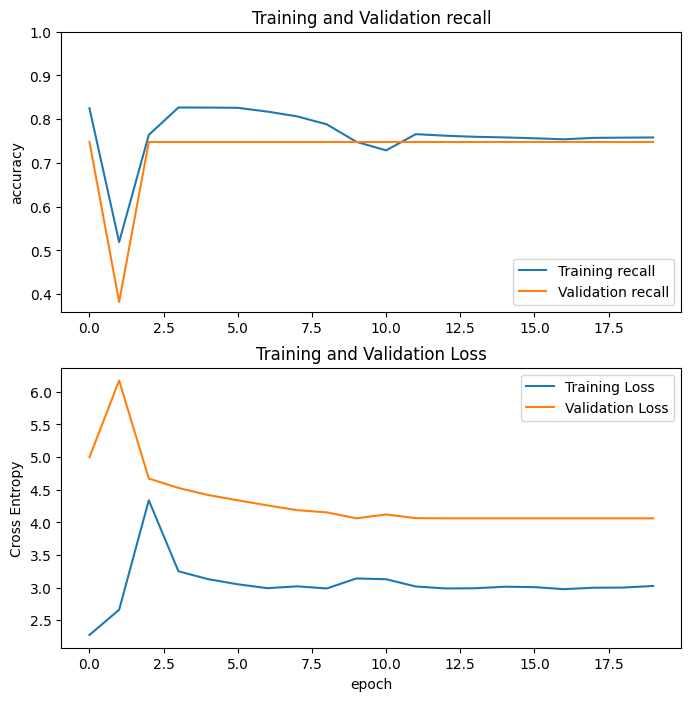

In [38]:
acc = history.history['recall_2']
val_acc = history.history['val_recall_2']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training recall')
plt.plot(val_acc, label='Validation recall')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation recall')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 62ms/step - loss: 4.0623 - recall_2: 0.7480


[4.062283992767334, 0.7479674816131592]

In [29]:
Y = []
for images, labels in test_ds:
    for label in labels:
        Y.append(label)

y_test = np.array(Y)
y_test=np.argmax(y_test,axis=1)

In [34]:
preds = model.predict(test_ds)
y_preds=np.argmax(preds,axis=1)

8/8 [==============================] - 0s 59ms/step


In [ ]:
cm = tf.math.confusion_matrix(y_test,y_preds)
cm

In [ ]:
temp = 1
tf.nn.softmax(preds/temp)

In [13]:
prev_model = keras.models.load_model("Models/ResNet50-STBv1.0_17")

In [14]:
prev_preds = prev_model.predict(test_ds)

8/8 [==============================] - 1s 62ms/step


In [18]:
prev_preds

array([[4.53154417e-03, 3.12282395e-06, 9.95465338e-01],
       [6.06396124e-02, 5.71045057e-05, 9.39303339e-01],
       [6.94732130e-01, 1.85124315e-02, 2.86755413e-01],
       [9.99998927e-01, 8.22286239e-09, 1.10338294e-06],
       [1.00000000e+00, 1.65076758e-10, 1.44687554e-10],
       [9.12578106e-01, 5.25059004e-05, 8.73693749e-02],
       [9.98959422e-01, 1.16388446e-06, 1.03934540e-03],
       [5.46989381e-01, 1.18780772e-04, 4.52891827e-01],
       [9.99991179e-01, 1.77538971e-06, 7.03336400e-06],
       [9.98581171e-01, 9.16323334e-05, 1.32719334e-03],
       [9.99999642e-01, 1.49498796e-08, 4.14590431e-07],
       [9.99998808e-01, 1.51012411e-08, 1.15019031e-06],
       [9.99985695e-01, 1.08723988e-07, 1.41547862e-05],
       [9.99999762e-01, 7.09233348e-08, 1.56168966e-07],
       [9.99988675e-01, 5.14213934e-06, 6.14909050e-06],
       [9.99979019e-01, 7.12079964e-06, 1.38289224e-05],
       [9.99136746e-01, 3.06691727e-05, 8.32723046e-04],
       [9.99805391e-01, 8.99455

In [15]:
np.argmax(prev_preds,axis=1)

array([2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                           

In [17]:
prev_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                             

In [65]:
model.layers[2].name

'resnet50'

In [37]:
layer_outputs = [layer.output for layer in model.layers if layer != 'resnet50']

In [40]:
layer_outputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'random_rotation')>,
 <KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'classification')>]

In [ ]:
a = [1, 2]

In [ ]:
model.layers[2].summary()

: 

In [41]:
activation_model = tf.keras.Model(inputs=model.input, outputs=layer_outputs[:])

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [ ]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs] 


In [ ]:
# Test the model with some sample data
x_test = tf.ones((1, 10))
y_pred = model.predict(x_test)
layer_outputs = activation_model.predict(x_test)

# Print the output values after each layer
for i, output in enumerate(layer_outputs):
    print(f"Output after layer {i}: {output}")
print(f"Final output: {y_pred}")